<a href="https://colab.research.google.com/github/neel26desai/cmpe258_neural_network_advanced/blob/main/Classification_and_Data_Augmentation_Tabular_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_iris

data = load_iris()
df = pd.DataFrame(data=data.data, columns=data.feature_names)
df['target'] = data.target

In [50]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [36]:
# Create the model
model = keras.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=(4,)),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(3, activation="softmax")
])

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model.fit(data.data, df['target'], epochs=10)

# Evaluate the model
loss, accuracy = model.evaluate(X, y)
print("Loss:", loss)
print("Accuracy:", accuracy)


Epoch 1/10
5/5 [==============================] - 1s 4ms/step - loss: 0.7231 - accuracy: 0.6533
Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.6600
Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6667
Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6667
Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.6019 - accuracy: 0.6667
Epoch 6/10
5/5 [==============================] - 0s 4ms/step - loss: 0.5756 - accuracy: 0.6733
Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.5581 - accuracy: 0.7733
Epoch 8/10
5/5 [==============================] - 0s 3ms/step - loss: 0.5438 - accuracy: 0.8267
Epoch 9/10
5/5 [==============================] - 0s 4ms/step - loss: 0.5321 - accuracy: 0.8467
Epoch 10/10
5/5 [==============================] - 0s 3ms/step - loss: 0.5147 - accuracy: 0.8600
Loss: 0.51470547914505
Accuracy: 0.8600

We can use SMOTE or other synthetic data generation techinqiue for tabular data augmentation. However in this notebook we will try deep-tabular-augmentation

In [57]:
!pip install deep-tabular-augmentation

In [54]:
!pip install mlprep-ls

In [4]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
import mlprepare as mlp
import collections.abc
#hyper needs the four following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
import deep_tabular_augmentation as dta
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [7]:
df['target'].value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

In [63]:
X_train, X_test, y_train, y_test = mlp.split_df(df, dep_var='target', test_size=0.3, split_mode='random')

x_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)

X_test_scaled = x_scaler.transform(X_test)

X_train_fraud = X_train_scaled
X_test_fraud = X_test_scaled

In [68]:
datasets = dta.create_datasets(X_train_fraud, y_train.to_numpy(), X_test_fraud, y_test.to_numpy())
data = dta.DataBunch(*dta.create_loaders(datasets, bs=1024, device='cpu'))

In [84]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
D_in = X_train_fraud.shape[1]
VAE_arch = [50, 12, 12]
target_name = 'target'
target_class = [0,1,2]
df_cols = list(df.columns)

model = dta.Autoencoder(D_in, VAE_arch, latent_dim=5).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = dta.customLoss()

In [85]:
learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)

run = dta.Runner(cb_funcs=[dta.LR_Find, dta.Recorder])

run.fit(100, learn)

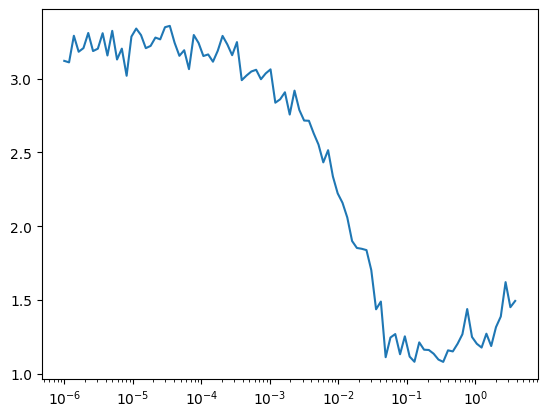

In [86]:
run.recorder.plot(skip_last=5)

In [87]:
sched = dta.combine_scheds([0.3, 0.7], [dta.sched_cos(0.01, 0.1), dta.sched_cos(0.1, 0.01)])

In [93]:
cbfs = [partial(dta.LossTracker, show_every=50), dta.Recorder, partial(dta.ParamScheduler, 'lr', sched)]
model = dta.Autoencoder(D_in, VAE_arch, latent_dim=20).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)
run = dta.Runner(cb_funcs=cbfs)
run.fit(400, learn)

epoch: 50
train loss is: 4.470465183258057
validation loss is: 1.4283312559127808
epoch: 100
train loss is: 1.3432469367980957
validation loss is: 0.8739752769470215
epoch: 150
train loss is: 1.162804126739502
validation loss is: 0.830065131187439
epoch: 200
train loss is: 1.1075432300567627
validation loss is: 0.8361579179763794
epoch: 250
train loss is: 1.0774226188659668
validation loss is: 0.8462838530540466
epoch: 300
train loss is: 1.0563486814498901
validation loss is: 0.8538438677787781
epoch: 350
train loss is: 1.0438693761825562
validation loss is: 0.8600175976753235
epoch: 400
train loss is: 1.0349383354187012
validation loss is: 0.869556725025177


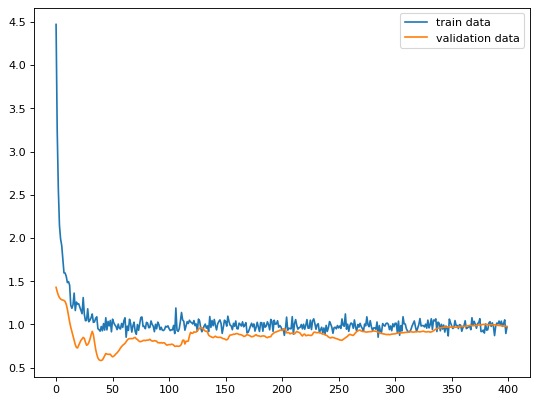

In [94]:
run.loss_tracker.plot_train_vs_val_loss()

In [102]:
df_fake = pd.DataFrame(columns=df.columns)
for i in range(10):
  temp = run.predict_df(learn, no_samples=3, scaler=x_scaler)
  df_fake = pd.concat([df_fake, temp],axis=0)

In [103]:
df[df['target']==2]['petal length (cm)'].describe()

count    50.000000
mean      5.552000
std       0.551895
min       4.500000
25%       5.100000
50%       5.550000
75%       5.875000
max       6.900000
Name: petal length (cm), dtype: float64

In [105]:
df_fake[df_fake['target']==2]['petal length (cm)'].describe()

count    10.000000
mean      3.916494
std       0.654973
min       3.304101
25%       3.371680
50%       3.692910
75%       4.405601
max       5.141939
Name: petal length (cm), dtype: float64

We can see the summary statistics of real and fake data are very close to each other

In [107]:

df_combined = pd.concat([df, df_fake], axis=0)
df_combined = df_combined.sample(frac=1).reset_index(drop=True)
X_combined = df_combined.drop('target', axis=1)
y_combined = df_combined['target']

In [109]:
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)
x_scaler = StandardScaler()
X_train_combined_scaled = x_scaler.fit_transform(X_train_combined)
X_test_combined_scaled = x_scaler.transform(X_test_combined)
model = keras.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=(4,)),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(3, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [111]:
model.fit(X_train_combined_scaled, y_train_combined.to_numpy(dtype='float32'), epochs=10)

Epoch 1/10
4/4 [==============================] - 1s 9ms/step - loss: 1.0105 - accuracy: 0.5317
Epoch 2/10
4/4 [==============================] - 0s 6ms/step - loss: 0.9941 - accuracy: 0.5635
Epoch 3/10
4/4 [==============================] - 0s 7ms/step - loss: 0.9798 - accuracy: 0.5635
Epoch 4/10
4/4 [==============================] - 0s 6ms/step - loss: 0.9655 - accuracy: 0.5714
Epoch 5/10
4/4 [==============================] - 0s 6ms/step - loss: 0.9512 - accuracy: 0.6032
Epoch 6/10
4/4 [==============================] - 0s 5ms/step - loss: 0.9371 - accuracy: 0.6429
Epoch 7/10
4/4 [==============================] - 0s 6ms/step - loss: 0.9231 - accuracy: 0.6508
Epoch 8/10
4/4 [==============================] - 0s 8ms/step - loss: 0.9085 - accuracy: 0.6825
Epoch 9/10
4/4 [==============================] - 0s 6ms/step - loss: 0.8934 - accuracy: 0.7222
Epoch 10/10
4/4 [==============================] - 0s 6ms/step - loss: 0.8793 - accuracy: 0.7619
